In [ ]:
# 设置R内核，在命令行运行
# jupyter kernelspec list
# install.packages('IRkernel')
# IRkernel::installspec()

# 建立Seurat对象

在本教程中，我们将分析来自10X Genomics免费提供的外周血单个核细胞（PBMC）数据集。这个数据集包含了2,700个单个细胞，这些细胞在Illumina NextSeq 500上进行了测序。原始数据可以在[这里](https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz)找到。

我们首先读取数据。`Read10X()`函数用于读取来自10X的[cellranger](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/what-is-cell-ranger)流水线的输出，返回一个唯一分子标识（UMI）计数矩阵。该矩阵中的值表示每个特征（即基因；行）在每个细胞（列）中检测到的分子数。请注意，最近版本的cellranger现在还可以使用[h5文件格式](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/advanced/h5_matrices)输出，可以使用Seurat中的`Read10X_h5()`函数进行读取。

接下来，我们使用计数矩阵创建一个`Seurat`对象。该对象作为一个容器，包含了单细胞数据集的数据（如计数矩阵）和分析（如PCA或聚类结果）。欲了解更多信息，请参阅我们的[Seurat对象交互vignette](https://github.com/satijalab/seurat/wiki)，或者我们的GitHub Wiki。例如，在Seurat v5中，计数矩阵存储在`pbmc[["RNA"]]$counts`中。

In [2]:
# 初始化
library(dplyr)
library(Seurat)
library(patchwork)

In [3]:
# Load the PBMC dataset
pbmc.data <- Read10X(data.dir = "/data/home/zhouy1/database_workshop/filtered_gene_bc_matrices/hg19")

# Initialize the Seurat object with the raw (non-normalized data).
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)

pbmc

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)
 1 layer present: counts

**在矩阵中的数据是什么样子的？**

In [4]:
# 我们来检测一下前30个细胞的一些基因
pbmc.data[c("CD3D","TCL1A","MS4A1"), 1:30]

  [[ suppressing 30 column names ‘AAACATACAACCAC-1’, ‘AAACATTGAGCTAC-1’, ‘AAACATTGATCAGC-1’ ... ]]



3 x 30 sparse Matrix of class "dgCMatrix"
                                                                   
CD3D  4 . 10 . . 1 2 3 1 . . 2 7 1 . . 1 3 . 2  3 . . . . . 3 4 1 5
TCL1A . .  . . . . . . 1 . . . . . . . . . . .  . 1 . . . . . . . .
MS4A1 . 6  . . . . . . 1 1 1 . . . . . . . . . 36 1 2 . . 2 . . . .

矩阵中的` . `值代表 0（未检测到分子）。由于单细胞RNA测序矩阵中大多数值都为 0，Seurat 在可能的情况下使用稀疏矩阵表示。这样做可以在 Drop-seq/inDrop/10x 数据中实现显著的内存和速度节省。

In [5]:
dense.size <- object.size(as.matrix(pbmc.data))
dense.size
sparse.size <- object.size(pbmc.data)
sparse.size
dense.size / sparse.size

709591472 bytes

29905192 bytes

23.7 bytes

# 标准的数据预处理流程

标准的单细胞转录组数据预处理流程如下所示，这代表了在Seurat中进行的标准预处理流程。这些步骤包括根据质控指标选择和过滤细胞，数据标准化和缩放，以及检测高度可变的特征。


## 质控和选择细胞进行进一步分析
Seurat允许您轻松地探索质控指标，并根据任何用户定义的标准过滤细胞。社区常用的一些质控指标包括

- 每个细胞中检测到的唯一基因数。
    - 低质量的细胞或空的液滴通常具有非常少的基因。
    - 细胞二倍体或多倍体可能表现出异常高的基因计数。
- 类似地，细胞内检测到的分子总数（与唯一基因强相关）
- 映射到线粒体基因组的读数百分比。
    - 低质量/死亡的细胞通常表现出大量的线粒体污染。
    - 我们使用PercentageFeatureSet()函数计算线粒体质控指标，该函数计算来自一组特征的计数的百分比。
    - 我们将以MT-开头的所有基因作为一组线粒体基因。

In [6]:
# [[操作符可以将列添加到对象元数据中。这是存储质控统计数据的适宜地方
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

**质控指标在存储Seurat中的哪里？**
- 唯一基因数和总分子数在`CreateSeuratObject()`函数期间会自动计算
    - 您可以在对象元数据中找到它们存储的位置

In [7]:
# qc
# 显示五个细胞的QC指标
head(pbmc@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACATACAACCAC-1,pbmc3k,2419,779,3.0177759
AAACATTGAGCTAC-1,pbmc3k,4903,1352,3.7935958
AAACATTGATCAGC-1,pbmc3k,3147,1129,0.8897363
AAACCGTGCTTCCG-1,pbmc3k,2639,960,1.7430845
AAACCGTGTATGCG-1,pbmc3k,980,521,1.2244898


在下面的示例中，我们可视化 QC 指标，并使用这些指标来过滤单元格。

我们过滤有nFeature_RNA超过200和小于2500的细胞

我们筛选线粒体计数大于5% 的细胞

注：“unique feature counts”通常指的是单细胞转录组数据中每个细胞中检测到的唯一特征的数量，而不是指UMI（Unique Molecular Identifier，唯一分子标识符）的数量。

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


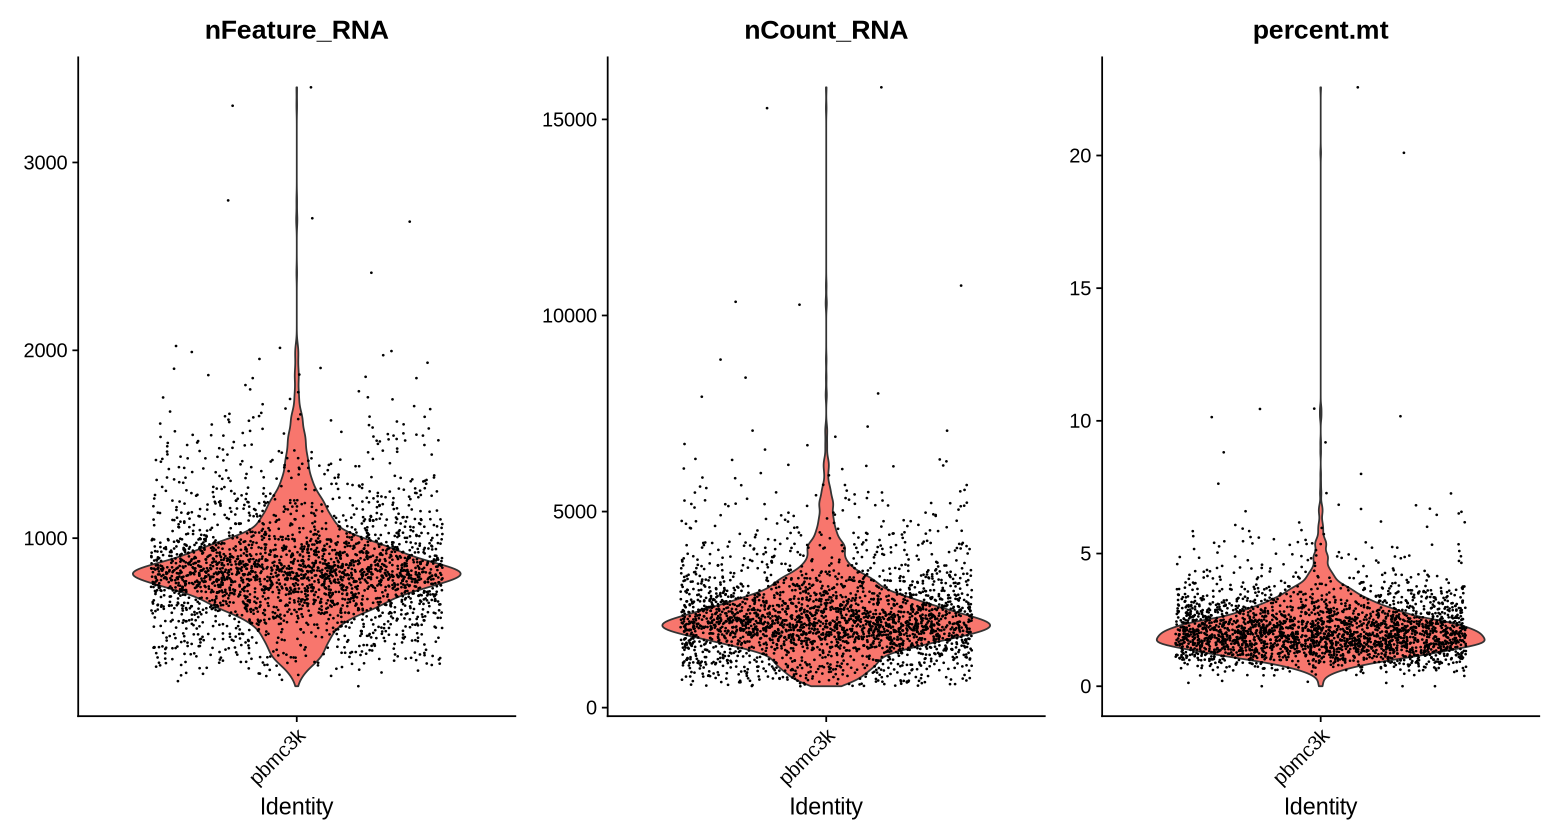

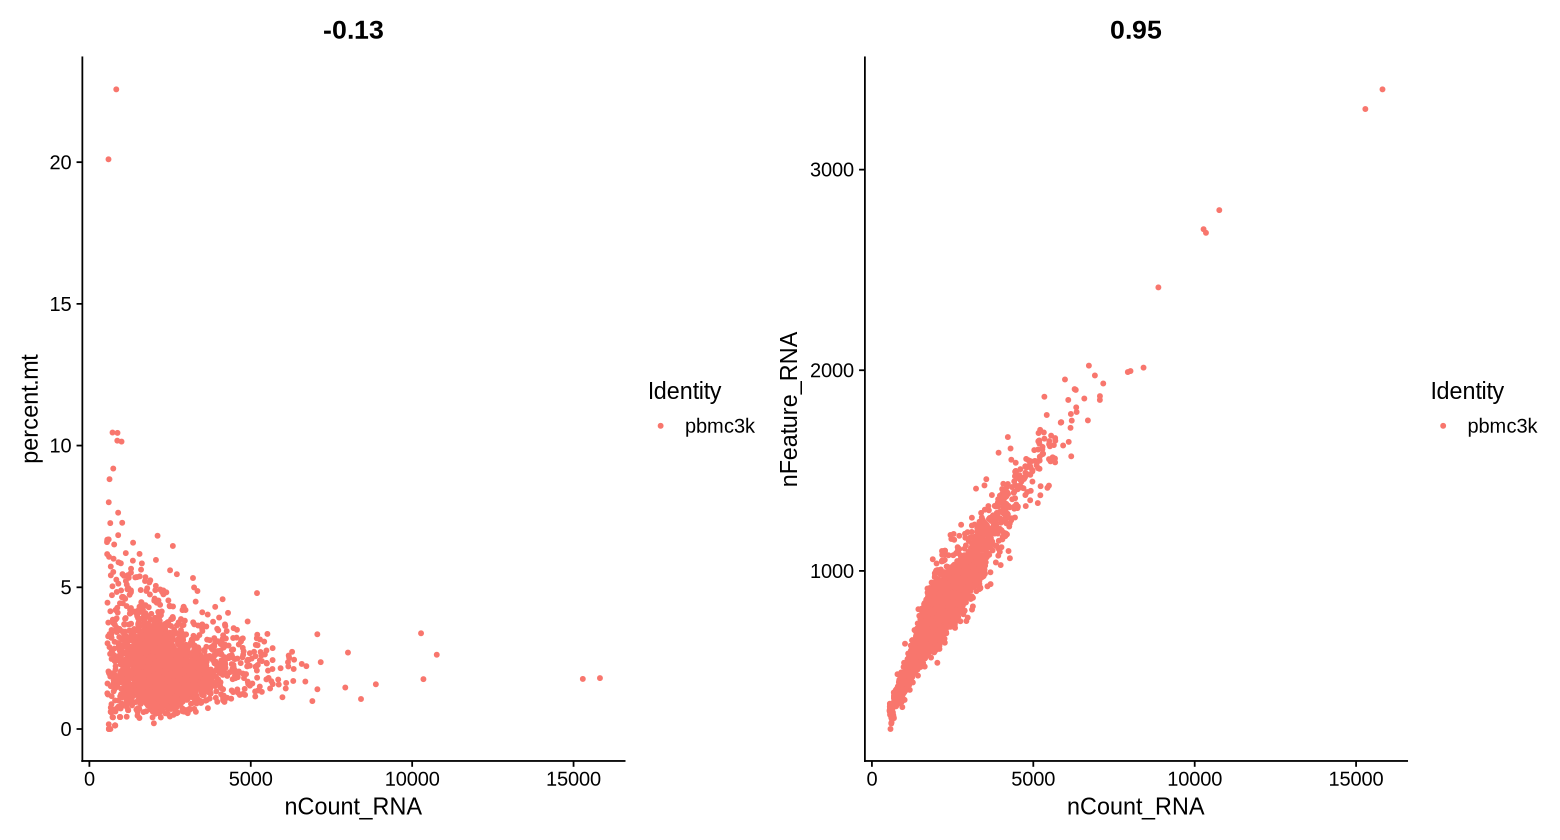

In [9]:
options(repr.plot.width=13, repr.plot.height=7) # 设置图形尺寸为宽5英寸，高3英寸

# 将 QC 指标可视化为小提琴图
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

# FeatureScatter 通常用于可视化特征-特征关系，但也可以用于对象计算的任何东西，比如对象元数据中的列、 PC 分数等等。

plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt") 
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA") 
plot1 + plot2

pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

---

# 归一化数据

从数据集中删除不需要的单元格后，下一步是对数据进行归一化。默认情况下，我们使用全局缩放归一化方法“LogNormalize”，该方法将每个单元的特征表达式测量值归一化为总表达式，乘以比例因子（默认情况下为10000），并对结果进行日志转换。在Seurat v5中，归一化值存储在`pbmc[[“RNA”]]$data`中。

In [ ]:
# 归一化
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 1e4)

需要澄清的是，在前一行代码中（以及在未来的命令中），我们在函数调用中提供了某些参数的默认值。但是，这不是必需的，并且可以通过以下方式实现相同的行为：

In [ ]:
# pbmc <- NormalizeData(pbmc)

这种标准化方法是单细胞RNA测序分析中常用且广泛使用的，但全局缩放方法依赖于一个假设，即每个细胞最初包含相同数量的RNA分子。我们和其他人已经开发了单细胞预处理的替代工作流程，不做这些假设。对于感兴趣的用户，请查看我们的`SCTransform()`标准化工作流程。该方法在我们的[论文](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02584-9
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        )中有描述，并且有一个单独的[示例](https://satijalab.org/seurat/articles/sctransform_vignette.html)在 Seurat 中。使用 `SCTransform` 就无需运行 `NormalizeData`、`FindVariableFeatures` 或 `ScaleData`（下面描述）。

# 高度可变特征的识别（特征选择）
接下来，我们计算数据集中表现出高细胞间变异性的一部分特征（即，在某些细胞中表达水平高，在其他细胞中表达水平低）。我们和[其他人](https://www.nature.com/articles/nmeth.2645) 发现，在下游分析中聚焦于这些基因有助于突出单细胞数据集中的生物信号。

我们在Seurat中的步骤在[此链接](https://doi.org/10.1016/j.cell.2019.05.031
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        )中有详细描述，并通过直接建模单细胞数据中固有的均值-方差关系改进了以前的版本，该方法实现在`FindVariableFeatures()`函数中。默认情况下，我们每个数据集返回2,000个特征。这些特征将在下游分析例如PCA中使用。

In [ ]:
options(repr.plot.width=10, repr.plot.height=5)

pbmc <- FindVariableFeatures(pbmc, selection.method = 'vst', nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(pbmc), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(pbmc)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1 + plot2

---

# 缩放数据
接下来，我们应用线性变换（“缩放”）进行标准化处理，这是在进行诸如PCA等降维技术之前的标准预处理步骤。ScaleData() 函数会做以下处理：

- 将每个基因的表达值移动，使得所有细胞中该基因的平均表达值为0。
- 对每个基因的表达值进行缩放，使得所有细胞中该基因的表达值的方差为1。
    - 这一步骤确保在后续的分析中，每个基因的表达值都能够得到同等的权重，从而避免高表达基因对结果的影响过大。
- 处理结果会存储在 `pbmc[["RNA"]]$scale.data` 中。
- 默认情况下，只有变化较大的特征会被标准化。
- 你也可以通过指定 features 参数来标准化其他特征。

In [ ]:
# regress results='hide'

all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

**如何删除不需要的变异源**

在Seurat中，我们可以使用ScaleData()函数来移除单细胞数据集中不需要的变异来源。例如，我们可以使用线性回归的方法来消除与特定因素（比如细胞周期阶段）相关的异质性。这个过程通常称为"regress out"。
具体步骤如下：

1. **标准化数据**： 首先，我们对数据进行标准化处理，通常使用ScaleData()函数。这会使每个基因的表达值被中心化和缩放，使其均值为0，方差为1。
2. **建模并移除**： 接下来，我们使用线性回归模型来建模我们感兴趣的因素对数据的影响，并将其从数据中移除。对于细胞周期阶段，我们可以将细胞周期阶段作为解释变量，然后通过线性回归来估计细胞周期阶段对基因表达的影响，并将其从数据中去除。
3. **获取纯净数据**： 最后，我们得到了已经移除了不需要的变异来源的数据，可以在这个基础上进行后续的分析，比如聚类、降维等。

In [ ]:
# regressvarmt eval = FALSE

pbmc <- ScaleData(pbmc, vars.to.regress = 'percent.mt')

---

# 执行线性降维
在Seurat中，尤其是对于希望使用这种功能的高级用户，我们强烈推荐使用我们的新的标准化工作流，即SCTransform()。该方法在我们的[论文](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02584-9
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        )中有描述，还有一个使用Seurat的[单独教程](https://satijalab.org/seurat/articles/sctransform_vignette)。与`ScaleData()`类似，`SCTransform()`函数也包括一个`vars.to.regress`参数。

执行线性降维
接下来我们对标准化后的数据进行PCA。默认情况下，只使用之前确定的可变特征作为输入，但如果您希望选择不同的子集，则可以使用features参数进行定义（如果您想使用自定义的特征子集，请确保您首先将它们传递给`ScaleData`）。

对于第一主成分，Seurat会输出具有最大正负载荷的基因列表，代表着在数据集中单细胞之间表现出相关性（或反相关性）的基因模块。

In [ ]:
# PCA results='hide'
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

Seurat提供了几种有用的方法来可视化定义PCA的细胞和特征，包括`VizDimReduction()`, `DimPlot()`和 `DimHeatmap()`

In [ ]:
# pca_viz message=TRUE
%%R -w 1000 -h 800

# 通过几种不同的方式检查和可视化PCA结果
print(pbmc[['pca']], dims = 1:5, nfeatures = 5)

In [ ]:
# pca_viz message=TRUE
%%R -w 1000 -h 800

VizDimLoadings(pbmc, dims = 1:2, reduction = 'pca')

In [ ]:
# pca_viz message=TRUE
%%R -w 1000 -h 800

DimPlot(pbmc, reduction = 'pca') + NoLegend()

特别是 DimHeatmap() 函数允许轻松地探索数据集中主要异质性的来源，在决定哪些主成分（PCs）用于进一步的下游分析时非常有用。

该函数会根据它们的PCA得分对细胞和特征进行排序。将 `cells` 设置为一个数字会在光谱的两端绘制'极端'细胞，这会极大地加速绘图过程，特别适用于大型数据集。

尽管这显然是一种有监督的分析方法，但我们发现这对于探索相关特征集合非常有价值。

In [ ]:
# single-heatmap
%%R -w 900 -h 600

DimHeatmap(pbmc, dims = 1, cells = 500, balanced = TRUE)

In [ ]:
# multi-heatmap
%%R -w 900 -h 1500

DimHeatmap(pbmc, dims = 1:15, cells = 500, balanced = TRUE)

# 确定数据集的“维度”
为了克服单细胞RNA测序数据中任何单个特征的大量技术噪声，Seurat根据它们的PCA得分对细胞进行聚类，每个主成分实质上代表着一个“元特征”，它将来自相关特征集的信息结合在一起。因此，前几个主成分代表了数据集的一个稳健的压缩。然而，我们应该选择包含多少个成分呢？10个？20个？100个？

在(Macosko *et al* )的[文章中](http://www.cell.com/abstract/S0092-8674(15)00549-8)，我们实施了一个受到JackStraw程序启发的重采样测试。虽然仍然可以在Seurat中使用[（参见前面的教程）](https://satijalab.org/seurat/articles/pbmc3k_tutorial)，但这是一个缓慢和计算成本高昂的过程，不再是单细胞分析中的常规方法。

一种替代的启发式方法是生成一个“拐点图”：基于每个主成分解释的方差百分比的排名（`ElbowPlot()`函数）。在这个例子中，我们可以观察到PC9-10附近有一个“拐点”，这表明大部分真实信号都包含在前10个主成分中。

In [ ]:
options(repr.plot.width=10, repr.plot.height=6)
ElbowPlot(pbmc)

确定数据集的真实维度对用户来说可能具有挑战性或不确定性。因此，我们建议用户尝试多种方法。

第一种方法更加有监督，通过探索主成分来确定相关的异质性来源，并可以与GSEA等方法结合使用。第二种方法（`ElbowPlot()`函数）和第三种是一种常用的启发式方法，可以立即计算得出。在这个例子中，我们可能可以在PC 7-12之间选择任何一个作为截止点。

我们在这里选择了10个主成分，但鼓励用户考虑以下内容：

- 树突状细胞和NK细胞的专家可能会认识到，与PCs 12和13强相关的基因定义了罕见的免疫亚群（例如，MZB1是浆细胞样树突状细胞的标记物）。然而，这些细胞群是如此罕见，以至于在没有先验知识的情况下，很难将它们与背景噪音区分开来。
- 我们鼓励用户使用不同数量的主成分（10个，15个，甚至50个）来重复下游分析。正如您将观察到的，结果通常不会有太大的差异。
- 我们建议用户在选择此参数时选择较高的值。例如，仅使用5个主成分进行下游分析会显着且不利地影响结果。

---

# 对细胞进行聚类

Seurat采用基于图的聚类方法，构建在[Macosko等人](http://www.cell.com/abstract/S0092-8674(15)00549-8)的初始策略基础上。重要的是，驱动聚类分析的*距离度量*（基于先前确定的主成分）保持不变。然而，我们对将细胞距离矩阵分区的方法已经得到了显著改进。我们的方法受到了最近将基于图的聚类方法应用于scRNA-seq数据[SNN-Cliq, Xu and Su, Bioinformatics, 2015](http://bioinformatics.oxfordjournals.org/content/early/2015/02/10/bioinformatics.btv088.abstract)和CyTOF数据[PhenoGraph, Levine et al., Cell, 2015](http://www.ncbi.nlm.nih.gov/pubmed/26095251)的手稿的启发。简而言之，这些方法将细胞嵌入到图结构中 - 例如KNN图(K-nearest neighbor graph)，其中边是在具有相似特征表达模式的细胞之间绘制的，并试图将该图分区为高度互连的'准团'或'社区'。

与PhenoGraph类似，我们首先基于PCA空间中的欧几里得距离构建了一个KNN图，并根据它们局部邻域的重叠共享来调整任意两个细胞之间的边权重（Jaccard相似性）。这一步骤使用`FindNeighbors()`函数完成，并以先前定义的数据集维度（前10个主成分）作为输入。

为了对细胞进行聚类，我们接下来应用模块性优化技术，如Louvain算法（默认）或SLM [SLM, Blondel et al., Journal of Statistical Mechanics](http://dx.doi.org/10.1088/1742-5468/2008/10/P10008
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        )，通过迭代将细胞分组在一起，目标是优化标准的模块性函数。`FindClusters()`函数实现了这个过程，并包含一个分辨率参数，用于设置下游聚类的“粒度”，增加该值会导致更多的簇被形成。我们发现将该参数设置在0.4-1.2之间通常对约3K个细胞的单细胞数据集返回良好的结果。对于更大的数据集，通常会增加最佳分辨率。可以使用`Idents()`函数找到聚类簇。


In [ ]:
# cluster
# 计算最邻近距离
pbmc <- FindNeighbors(pbmc, dims = 1:10)
#聚类，包含设置下游聚类的“间隔尺度”的分辨率参数resolution ，增加值会导致更多的聚类。
pbmc <- FindClusters(pbmc, resolution = 0.5)
#可以使用idents函数找到聚类情况：
# 查看前5个单元的集群 ID
head(Idents(pbmc), 5)

---

Seurat 提供了一些非线性降维技术，如 tSNE 和 UMAP，来可视化和探索这些数据集。这些算法的目标是学习数据集中的底层结构，以便在低维空间中将相似的单元放在一起。因此，在上面确定的基于图表的簇中分组在一起的细胞应该在这些维度减化上共定位。

虽然我们发现像 tSNE 和 UMAP 这样的二维可视化技术是探索数据集的有价值的工具，但是所有的可视化技术都有局限性，不能完全代表底层数据的复杂性。特别是，这些方法旨在保持数据集中的局部距离(即确保具有非常相似的基因表达谱的细胞共定位) ，但通常不能保持更多的全局关系。我们鼓励用户利用像 UMAP 这样的技术进行可视化，但避免仅仅基于可视化技术得出生物学结论。

In [ ]:
# umap
pbmc <- RunUMAP(pbmc, dims = 1:10)

In [ ]:
# umapplot
%%R -w 800 -h 800

# 请注意，您可以设置`label = TRUE`或使用 `LabelClusters` 函数来帮助标记单个集群
DimPlot(pbmc, reduction = 'umap')

此时可以保存对象，这样就可以轻松地将其加载回，而无需重新运行上面执行的计算密集型步骤，也无需与合作者轻松共享。

In [ ]:
# saveobject
saveRDS(pbmc, file = "../output/pbmc_tutorial.rds")

---

# 寻找差异表达的特征(聚类生物标志物)

在Seurat中，您可以通过差异表达（DE）来找到定义聚类的标记物。默认情况下，它会识别单个聚类（在`ident.1`中指定）与所有其他细胞相比的正向和负向标记物。`FindAllMarkers()`函数会自动化这个过程，对所有聚类进行差异表达分析，但您也可以将一组聚类与另一组聚类或与所有细胞进行比较。

在Seurat v5中，我们使用了presto包（如[此处](https://www.biorxiv.org/content/10.1101/653253v1
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        )描述，并可在[此处](https://github.com/immunogenomics/presto)安装），以显著提高DE分析的速度，特别是对于大型数据集。对于不使用presto的用户，您可以查看该函数的文档（?FindMarkers）以探索`min.pct`和`logfc.threshold`参数，可以增加这些参数以提高DE测试的速度。

In [ ]:
# r markers1

# 找到cluster 2的所有markers
cluster2.markers <- FindMarkers(pbmc, ident.1 = 2)
head(cluster2.markers, n = 5)
# 找到区分cluster5与cluster0和cluster3的所有markers
cluster5.markers <- FindMarkers(pbmc, ident.1 = 5, ident.2 = c(0, 3))
head(cluster5.markers, n = 5)
# 与所有剩余细胞相比，为每个cluster找到标记，只报告阳性细胞
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE)
pbmc.markers %>%
    group_by(cluster) %>%
    dplyr::filter(avg_log2FC > 1)

Seurat有几个差分表达式测试，可以使用test.use参数进行设置（有关详细信息，请参阅我们的[DE vignette]（DE_vignette.html））。例如，ROC测试返回任何单个标记的“classification power”（从0-random到1-classification power）。

In [ ]:
# markersroc
cluster0.markers <- FindMarkers(pbmc, ident.1 = 0, logfc.threshold = 0.25, test.use = "roc", only.pos = TRUE)

我们提供了几个可视化标记表达的工具。

`VlnPlot()`（显示聚类之间的表达式概率分布）和`FeaturePlot()`（在tSNE或PCA图上可视化特征表达式）是我们最常用的可视化方法。

我们还建议探索`RidgePlot()`, `CellScatter()`和 `DotPlot()`作为查看数据集的其他方法

In [ ]:
# markerplots
options(repr.plot.width=10, repr.plot.height=8)

VlnPlot(pbmc, features = c("MS4A1", "CD79A"))
# 你也可以绘制原始计数的图
VlnPlot(pbmc, features = c("NKG7", "PF4"), slot = 'counts', log = TRUE)

In [ ]:
options(repr.plot.width=10, repr.plot.height=8)

FeaturePlot(pbmc, features = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP", "CD8A"))

查看特定基因在cluster中的表达山脊图

In [ ]:
features <- c("LYZ", "CCL5")
RidgePlot(pbmc, features = features, ncol = 2)

查看特定基因在cluster中的分布点图，点的大小代表表达该基因的细胞比例，颜色代表平均表达水平

In [ ]:
DotPlot(pbmc, features = features) + RotatedAxis()

`DoHeatmap()` 为给定的细胞和特征生成表达式热图。在本例中，我们为每个集群绘制前20个标记(如果小于20，则绘制所有标记)。

In [ ]:
# clusterHeatmap
options(repr.plot.width=10, repr.plot.height=8)

pbmc.markers %>%
    group_by(cluster) %>%
    dplyr::filter(avg_log2FC > 1) %>%
    slice_head(n = 10) %>%
    ungroup() -> top10
DoHeatmap(pbmc, features = top10$gene) + NoLegend()

------------------------------------------------------------------------

# 为聚类分配细胞类型注释

幸运的是，在这个数据集的情况下，我们可以使用规范标记轻松地将无偏聚类与已知细胞类型相匹配：

| Cluster ID | Markers       | Cell Type    |
|------------|---------------|--------------|
| 0          | IL7R, CCR7    | Naive CD4+ T |
| 1          | CD14, LYZ     | CD14+ Mono   |
| 2          | IL7R, S100A4  | Memory CD4+  |
| 3          | MS4A1         | B            |
| 4          | CD8A          | CD8+ T       |
| 5          | FCGR3A, MS4A7 | FCGR3A+ Mono |
| 6          | GNLY, NKG7    | NK           |
| 7          | FCER1A, CST3  | DC           |
| 8          | PPBP          | Platelet     |

In [ ]:
# labelplot
options(repr.plot.width=10, repr.plot.height=8)

new.cluster.ids <- c("Naive CD4 T", "CD14+ Mono", "Memory CD4 T", "B", "CD8 T", "FCGR3A+ Mono", "NK", "DC", "Platelet")
names(new.cluster.ids) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, new.cluster.ids)
DimPlot(pbmc, reduction = 'umap', label = TRUE, pt.size = 0.5) + NoLegend()

In [ ]:
# 保存图片
library(ggplot2)
plot <- DimPlot(pbmc, reduction = "umap", label = TRUE, label.size = 4.5) + xlab("UMAP 1") + ylab("UMAP 2") + 
  theme(axis.title = element_text(size = 18), legend.text = element_text(size = 18)) + 
  guides(colour = guide_legend(override.aes = list(size = 10)))
ggsave(filename = "../output/images/pbmc3k_umap.jpg", height = 7, width = 12, plot = plot, quality = 50)

In [ ]:
# save.rds, eval=FALSE}
saveRDS(pbmc, file = "../output/pbmc3k_final.rds")

In [ ]:
# save.times, include = FALSE
write.csv(x = t(as.data.frame(all_times)), file = "../output/timings/pbmc3k_tutorial_times.csv")

**Session Info**

In [ ]:
sessionInfo()